<h1> <font color = "Cyan"> <b> CS 419 Assignment 2 </font></h3>
<h3> <font color = "lime"> Ataberk Asil Karaman - 28945 </font></h3>




## **Question 1**

* Load the grayscale image using OpenCV.
* Design functions for the red, green, and blue channels. These
functions will map the grayscale pixel values to their color intensities. To achieve: <font color = "crimson"><b> dark areas to purple and bright areas to bright orange </b></font>
* Apply the colorization functions to the grayscale image to create a colorized image.
* Plot the functions for red, green, and blue to visualize how they map the grayscale values to color intensities.
* Display the original grayscale image and the colorized image.


In [224]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io import BytesIO
from matplotlib import image as mpimg


In [ ]:
image = cv2.imread("/content/drive/MyDrive/CS419/HW2/q1_kaplumbaga_terbiyecisi_osman_hamdi_bey.jpg", cv2.IMREAD_GRAYSCALE)

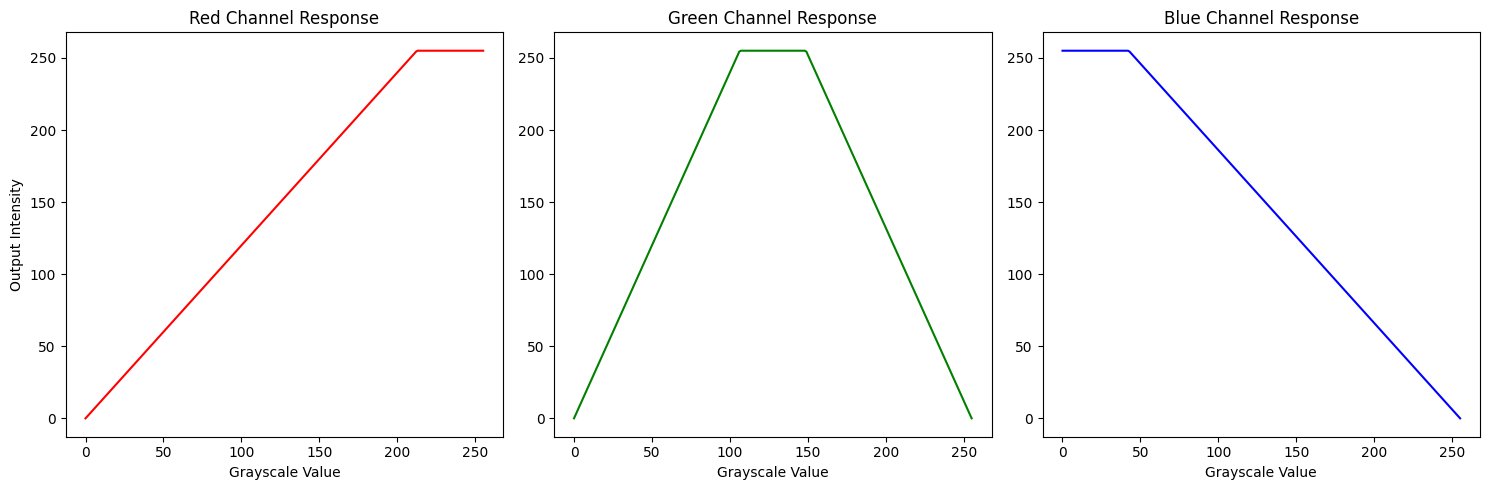

In [ ]:
def design_color_functions():
    red_func = lambda p: np.clip(1.2 * p, 0, 1)
    green_func = lambda p: np.clip(1.2 * (1 - np.abs(1 - 2 * p)), 0, 1)
    blue_func = lambda p: np.clip(1.2 * (1 - p), 0, 1)
    return red_func, green_func, blue_func

# Define and get the color functions
red_function, green_function, blue_function = design_color_functions()

# Create an array of grayscale values from 0 to 255
grayscale_values = np.linspace(0, 255, 256)

# Apply color functions to the grayscale values
red_output = red_function(grayscale_values / 255.0) * 255
green_output = green_function(grayscale_values / 255.0) * 255
blue_output = blue_function(grayscale_values / 255.0) * 255

# Plotting each channel's output
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(grayscale_values, red_output, 'r')
plt.title('Red Channel Response')
plt.xlabel('Grayscale Value')
plt.ylabel('Output Intensity')

plt.subplot(1, 3, 2)
plt.plot(grayscale_values, green_output, 'g')
plt.title('Green Channel Response')
plt.xlabel('Grayscale Value')

plt.subplot(1, 3, 3)
plt.plot(grayscale_values, blue_output, 'b')
plt.title('Blue Channel Response')
plt.xlabel('Grayscale Value')

plt.tight_layout()
plt.show()



In [ ]:
# Function to apply the color functions to the grayscale image and transform to RGB space
def colorize_with_custom_functions(image, red_func, green_func, blue_func, matrix_xyz_to_rgb):
    # Create an output image of the same dimensions as the input image, but with 3 channels for RGB
    colorized_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # Iterate over each pixel to apply the color functions
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Get the grayscale value normalized to [0, 1]
            p = image[i, j] / 255.0
            # Apply the color functions
            r, g, b = red_func(p), green_func(p), blue_func(p)
            # Create an XYZ color with Y from grayscale and X, Z from red and blue channels
            xyz = np.array([r, p, b])
            # Convert XYZ to RGB using the provided matrix
            rgb = np.dot(matrix_xyz_to_rgb, xyz)
            # Clip and convert to uint8
            colorized_image[i, j] = np.clip(rgb * 255, 0, 255).astype(np.uint8)

    return colorized_image

In [ ]:
# Transformation matrix seen in class
matrix_xyz_to_rgb = np.array([
    [3.2404542, -1.5371385, -0.4985314],
    [-0.9692660, 1.8760108, 0.0415560],
    [0.0556434, -0.2040259, 1.0572252]
])

# Colorize the grayscale image using the custom color functions
colorized_image = colorize_with_custom_functions(image, red_function, green_function, blue_function, matrix_xyz_to_rgb)

# Display the original and colorized images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colorized_image)
plt.title('Colorized Image with Custom Functions')
plt.axis('off')

plt.show()


## **Question 2**

* Shall be solved by <b>closing by reconstruction.</b>
1. Apply morphological dilation to the binary image.
2. Reconstruck by eroding it untill two step consequetive steps give same result.

In [220]:
# Define the structuring element (kernel) for dilation and erosion
kernel_e = np.ones((3, 3), np.uint8)
kernel_d = np.ones((13,13), np.uint8)
# Load the image
img = cv2.imread("/content/drive/MyDrive/CS419/HW2/q2_wheel.png", cv2.IMREAD_GRAYSCALE)

In [221]:
def grayscale_dilate(image, kernel):
    """Perform a grayscale dilation on the image using the given kernel."""
    dilated = np.zeros_like(image)
    pad_height, pad_width = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    for i in range(pad_height, padded_image.shape[0] - pad_height):
        for j in range(pad_width, padded_image.shape[1] - pad_width):
            # Find the maximum pixel value within the area of the structuring element
            dilated[i-pad_height, j-pad_width] = np.max(padded_image[i-pad_height:i+pad_height+1, j-pad_width:j+pad_width+1][kernel > 0])

    return dilated


In [222]:
# Function to perform binary erosion by complement and dilation
def grayscale_erode(input, kernel):
    # Take the complement (invert) of the input image
    inverted_input = 255 - input

    # Apply dilation to the inverted image
    dilated_inverted = grayscale_dilate(inverted_input, kernel)

    # Take the complement of the result to get the eroded image
    eroded_output = 255 - dilated_inverted

    return eroded_output


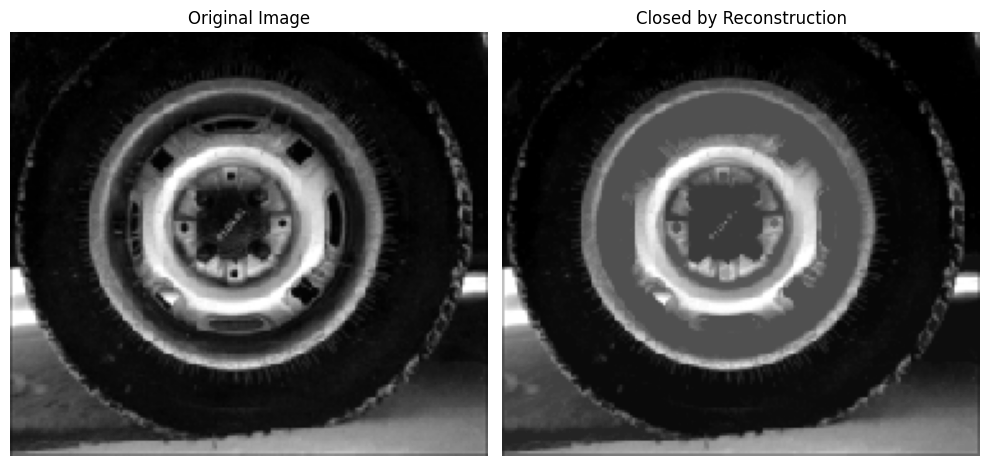

In [ ]:
def morphological_reconstruct(marker, mask, kernel):
    """Perform the morphological reconstruction of the marker image under the mask image."""
    while True:
        # Dilation step
        dilated = grayscale_dilate(marker, kernel)
        # Intersection step (conditional dilation)
        next_marker = np.minimum(dilated, mask)
        # Check for stability: if marker doesn't change, reconstruction is complete
        if np.array_equal(next_marker, marker):
            break
        marker = next_marker
    return marker

def fill_holes(img, kernel_e, kernel_d):
    """Fill the holes in the grayscale image."""
    # Invert the image to make the holes the highest intensity
    inverted_img = 255 - img

    # Erode the inverted image to create the marker
    marker = grayscale_erode(inverted_img, kernel_e)

    # Perform the reconstruction
    filled_image = morphological_reconstruct(marker, inverted_img, kernel_d)

    # Invert the image back to original form
    return (255 - filled_image)

# Apply the hole filling operation
filled_img = fill_holes(img, kernel_d, kernel_e)

# Display the original and filled images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Specify the grayscale colormap
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filled_img, cmap='gray')  # Specify the grayscale colormap
plt.title('Closed by Reconstruction')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def morphological_reconstruct(marker, mask, kernel):
    """Perform the morphological reconstruction of the marker image under the mask image."""
    while True:
        # Dilation step
        dilated = grayscale_dilate(marker, kernel)
        # Intersection step (conditional dilation)
        next_marker = np.minimum(dilated, mask)
        # Check for stability: if marker doesn't change, reconstruction is complete
        if np.array_equal(next_marker, marker):
            break
        marker = next_marker
    return marker

def fill_holes(img, kernel_e, kernel_d):
    """Fill the holes in the grayscale image."""
    # Invert the image to make the holes the highest intensity
    inverted_img = 255 - img

    # Erode the inverted image to create the marker
    marker = grayscale_erode(inverted_img, kernel_e)

    # Perform the reconstruction
    filled_image = morphological_reconstruct(marker, inverted_img, kernel_d)

    # Invert the image back to original form
    return (255 - filled_image)

# Apply the hole filling operation
filled_img = fill_holes(img, kernel_d, kernel_e)

# Display the original and filled images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Specify the grayscale colormap
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filled_img, cmap='gray')  # Specify the grayscale colormap
plt.title('Closed by Reconstruction')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Question 3**



In [ ]:
# Load the image using OpenCV
image = cv2.imread("/content/drive/MyDrive/CS419/HW2/q3_pompeii.png", cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded properly
if image is None:
    raise ValueError("Image not loaded. Check the file path.")


(544, 900)


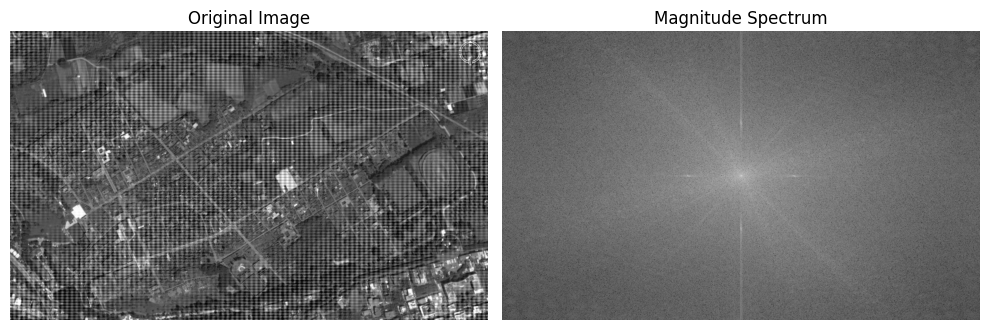

In [ ]:
# Compute the Fourier Transform of the image
f_transform = np.fft.fft2(image)
# Shift the zero frequency component to the center
f_shift = np.fft.fftshift(f_transform)

# Magnitude spectrum of the Fourier Transform
magnitude_spectrum = 20 * np.log(np.abs(f_shift))

# Display the original image and its Fourier Transform

print(image.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Create a band reject filter function
def apply_band_reject_filter(f_shift, center, radius, width):
    rows, cols = f_shift.shape
    mask = np.ones(f_shift.shape, np.uint8)
    c_row, c_col = np.ogrid[:rows, :cols]
    dist_from_center = (c_row - center[0])**2 + (c_col - center[1])**2

    # Create the band reject filter
    mask[(dist_from_center >= (radius-width)**2) & (dist_from_center <= (radius+width)**2)] = 0

    # Apply the mask to the Fourier Transform
    f_shift_filtered = f_shift * mask
    return f_shift_filtered

noise_freq = 120
rows = image.shape[0]
cols = image.shape[1]
# Apply the filter with initial parameters
center = (rows//2 + noise_freq , cols//2 + noise_freq * 0.6)  # Adjust based on visual inspection
radius = 15  # Start with a small radius and increase as needed
width = 3    # Start with a narrow width and adjust as needed
f_shift_filtered = apply_band_reject_filter(f_shift, center, radius, width)


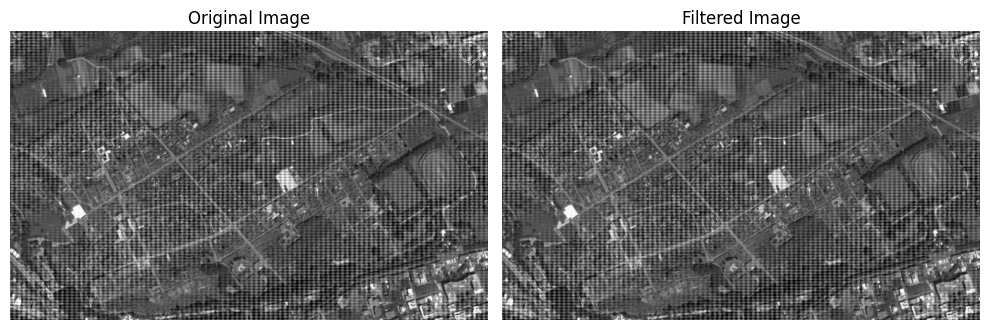

In [ ]:
# Compute the inverse Fourier Transform
f_ishift = np.fft.ifftshift(f_shift_filtered)
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)

# Normalize and display the filtered image
img_filtered_normalized = np.uint8(np.clip(img_filtered, 0, 255))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_filtered_normalized, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()


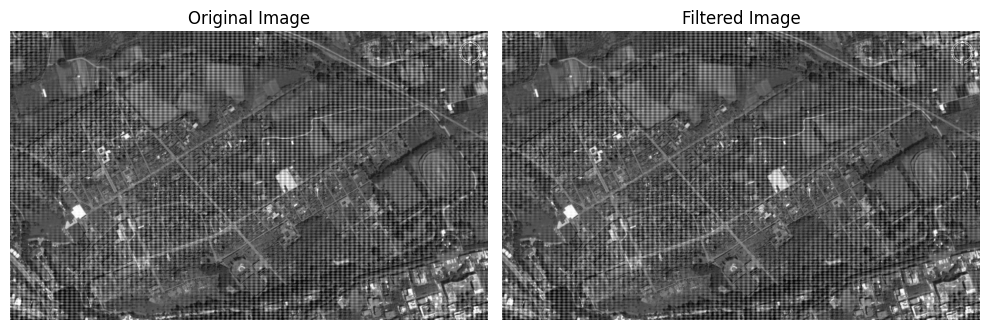

In [ ]:
# Coordinates of noise frequencies are assumed to be identified here
# For demonstration, let's assume the noise frequencies are at (x, y) = (60, 60) and symmetric points
# These would be updated with the actual coordinates from the visual inspection of the magnitude spectrum

# Dimensions of the image
rows, cols = image.shape
center_row, center_col = rows // 2, cols // 2

# Band reject filter parameters
noise_frequency = 160  # This would be identified from the spectrum
radius = 3 # Radius of the rejection band

# Initialize the mask with ones
mask = np.ones((rows, cols), np.uint8)

# Create the band reject filter
for u in range(-radius, radius + 1):
    for v in range(-radius, radius + 1):
        # Suppress the noise frequency and its symmetric counterpart
        if (center_row + noise_frequency + u) < rows and (center_col + noise_frequency + v) < cols:
            mask[center_row + noise_frequency + u, center_col + noise_frequency + v] = 0
            mask[center_row - noise_frequency + u, center_col - noise_frequency + v] = 0
            mask[center_row + noise_frequency + u, center_col - noise_frequency + v] = 0
            mask[center_row - noise_frequency + u, center_col + noise_frequency + v] = 0

# Apply the mask to the shifted Fourier Transform by element-wise multiplication
f_shift_masked = f_shift * mask

# Compute the inverse shift to move the zero frequency component back to the original position
f_ishift = np.fft.ifftshift(f_shift_masked)

# Compute the inverse Fourier Transform
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Normalize the resulting image to the range 0 to 255 and convert to uint8
img_denoised = np.uint8(np.clip(img_back, 0, 255))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_denoised, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Question 4**

In [ ]:
labeled_1 = cv2.imread("/content/drive/MyDrive/CS419/HW2/labeled-1.jpg", cv2.IMREAD_GRAYSCALE)
labeled_2 = cv2.imread("/content/drive/MyDrive/CS419/HW2/labeled-2.jpg", cv2.IMREAD_GRAYSCALE)
labeled_3 = cv2.imread("/content/drive/MyDrive/CS419/HW2/labeled-3.jpg", cv2.IMREAD_GRAYSCALE)
unlabeled_a = cv2.imread("/content/drive/MyDrive/CS419/HW2/unlabeled-A.jpg", cv2.IMREAD_GRAYSCALE)
unlabeled_b = cv2.imread("/content/drive/MyDrive/CS419/HW2/unlabeled-B.jpg", cv2.IMREAD_GRAYSCALE)
unlabeled_c = cv2.imread("/content/drive/MyDrive/CS419/HW2/unlabeled-C.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
# Load images (paths to be provided)
labeled_images = {
    'type1': labeled_1,
    'type2': labeled_2,
    'type3': labeled_3
}
unlabeled_images = {
    'A': unlabeled_a,
    'B': unlabeled_b,
    'C': unlabeled_c
}

# Function to perform opening by reconstruction using the revised erosion and dilation
def opening_by_reconstruction(image, kernel):
    eroded = grayscale_erode(image, kernel)
    reconstructed = grayscale_dilate(eroded, kernel)
    return reconstructed

# Function to calculate granulometry using the opening by reconstruction
def calculate_granulometry(image, kernel_sizes):
    granulometry = []
    for size in kernel_sizes:
        kernel = np.ones((size, size), np.uint8)
        opened_image = opening_by_reconstruction(image, kernel)
        granulometry.append(np.sum(opened_image))
    return granulometry

# Function to calculate distance and print the result
def calculate_distance(granulometry1, granulometry2, method='euclidean'):
    arr1, arr2 = np.array(granulometry1), np.array(granulometry2)
    if method == 'euclidean':
        distance = np.linalg.norm(arr1 - arr2)
    elif method == 'manhattan':
        distance = np.sum(np.abs(arr1 - arr2))
    elif method == 'chebyshev':
        distance = np.max(np.abs(arr1 - arr2))
    print(f"Distance ({method}): {distance}")
    return distance

kernel_sizes = [3, 5, 7, 9, 11, 13]  # example sizes, to be tuned

# Calculate granulometries for labeled images
labeled_granulometries = {
    key: calculate_granulometry(img, kernel_sizes)
    for key, img in labeled_images.items()
}

# Process and identify unlabeled images for each kernel and distance
for kernel_size in kernel_sizes:
    print(f"\nProcessing with kernel size: {kernel_size}")
    for distance_method in ['euclidean', 'manhattan', 'chebyshev']:
        print(f"\nUsing {distance_method} distance:")
        unlabeled_results = {}
        for key, img in unlabeled_images.items():
            unlabeled_granulometry = calculate_granulometry(img, [kernel_size])
            distances = {
                l_key: calculate_distance(labeled_granulometries[l_key], unlabeled_granulometry, distance_method)
                for l_key in labeled_granulometries
            }
            closest_match = min(distances, key=distances.get)
            unlabeled_results[key] = closest_match
            print(f"Image {key} matched with {closest_match}")



Processing with kernel size: 3

Using euclidean distance:
Distance (euclidean): 31864640.727232043
Distance (euclidean): 1.8446744073709345e+19
Distance (euclidean): 4.5185110396226626e+19
Image A matched with type1
Distance (euclidean): 50302124.21245165
Distance (euclidean): 33666572.207245156
Distance (euclidean): 4.518511039624558e+19
Image B matched with type2
Distance (euclidean): 134266593.67152593
Distance (euclidean): 117282174.38019766
Distance (euclidean): 33089312.64884301
Image C matched with type3

Using manhattan distance:
Distance (manhattan): 74720653
Distance (manhattan): 33041744
Distance (manhattan): 18446744073534921144
Image A matched with type2
Distance (manhattan): 121131607
Distance (manhattan): 79452698
Distance (manhattan): 18446744073581332098
Image B matched with type2
Distance (manhattan): 328109971
Distance (manhattan): 286431062
Distance (manhattan): 78758846
Image C matched with type3

Using chebyshev distance:
Distance (chebyshev): 18449137
Distance (

## **Question 5**



In [ ]:
RGB1 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_1.jpeg",  cv2.IMREAD_COLOR)
RGB1 = cv2.cvtColor(RGB1, cv2.COLOR_BGR2RGB)

RGB2 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_2.jpeg", cv2.IMREAD_COLOR)
RGB2 = cv2.cvtColor(RGB2, cv2.COLOR_BGR2RGB)

RGB3 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_3.jpeg")
RGB3 = cv2.cvtColor(RGB3, cv2.COLOR_BGR2RGB)

RGB4 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_4.jpg")
RGB4 = cv2.cvtColor(RGB4, cv2.COLOR_BGR2RGB)

RGB5 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_5.jpg", cv2.IMREAD_COLOR)
RGB5 = cv2.cvtColor(RGB5, cv2.COLOR_BGR2RGB)

RGB6 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_6.jpg")
RGB6 = cv2.cvtColor(RGB6, cv2.COLOR_BGR2RGB)

RGB7 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_7.jpg", cv2.IMREAD_COLOR)
RGB7 = cv2.cvtColor(RGB7, cv2.COLOR_BGR2RGB)

RGB8 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_8.jpg", cv2.IMREAD_COLOR)
RGB8 = cv2.cvtColor(RGB8, cv2.COLOR_BGR2RGB)

RGB9 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_9.jpg", cv2.IMREAD_COLOR)
RGB9 = cv2.cvtColor(RGB9, cv2.COLOR_BGR2RGB)

RGB10 = cv2.imread("/content/drive/MyDrive/CS419/HW2/q5_10.jpg", cv2.IMREAD_COLOR)
RGB10 = cv2.cvtColor(RGB10, cv2.COLOR_BGR2RGB)

In [ ]:
def add_salt_pepper_noise(image, noise_level):
    rows, cols, _ = image.shape
    num_pixels = int(noise_level * image.size / 2)
    temp = image.copy()

    # Add Salt (white) noise
    for _ in range(num_pixels):
        y = np.random.randint(0, rows)
        x = np.random.randint(0, cols)
        temp[y, x] = [255, 255, 255]

    # Add Pepper (black) noise
    for _ in range(num_pixels):
        y = np.random.randint(0, rows)
        x = np.random.randint(0, cols)
        temp[y, x] = [0, 0, 0]

    return temp

In [ ]:
def median_filter_marginal(image, kernel_size):
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    # Padding amount on each side of the image
    pad_size = kernel_size // 2

    # Pad the image with edge values to handle borders
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'edge')

    # Initialize output image
    filtered_image = np.zeros_like(image)

    # Apply median filter for each channel separately
    for channel in range(image.shape[2]):
        for i in range(image.shape[0]):  # Rows
            for j in range(image.shape[1]):  # Columns
                # Extract the current kernel window
                kernel_window = padded_image[i:i + kernel_size, j:j + kernel_size, channel]

                # Compute the median and assign it to the output image
                filtered_image[i, j, channel] = np.median(kernel_window)

    return filtered_image

In [ ]:
def median_filter_lexicographical(image, kernel_size):
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'edge')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):  # Rows
        for j in range(image.shape[1]):  # Columns
            # Extract kernel window
            kernel_window = padded_image[i:i+kernel_size, j:j+kernel_size, :]
            # Flatten the kernel window and sort it lexicographically
            flattened_vectors = kernel_window.reshape(-1, 3)
            sorted_vectors = sorted(flattened_vectors, key=lambda x: (x[0], x[1], x[2]))

            # Find the median vector
            median_vector = sorted_vectors[len(sorted_vectors) // 2]

            # Assign the median to the current pixel
            filtered_image[i, j] = median_vector

    return filtered_image


In [ ]:
def bitmix_color(r, g, b):
    # Define a strategy to mix the bits of the RGB values
    # This is a placeholder for the actual bitmixing strategy
    return (r << 16) | (g << 8) | b

def unmix_color(mixed_val):
    # Reverse the bitmixing to obtain the original RGB values
    r = (mixed_val >> 16) & 255
    g = (mixed_val >> 8) & 255
    b = mixed_val & 255
    return [r, g, b]

def vector_median_bitmix(image, kernel_size):
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'edge')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):  # Rows
        for j in range(image.shape[1]):  # Columns
            kernel_window = padded_image[i:i+kernel_size, j:j+kernel_size, :]
            # Apply bitmixing and sort
            mixed_values = [bitmix_color(*pixel) for pixel in kernel_window.reshape(-1, 3)]
            mixed_values.sort()

            # Find median and unmix
            median_mixed = mixed_values[len(mixed_values) // 2]
            median_color = unmix_color(median_mixed)

            # Assign the median color to the current pixel
            filtered_image[i, j] = median_color

    return filtered_image


In [ ]:
def vector_norm(pixel):
    # Calculate the Euclidean norm of the RGB vector
    return np.sqrt(np.sum(np.square(pixel)))

def median_filter_norm_based(image, kernel_size):
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'edge')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):  # Rows
        for j in range(image.shape[1]):  # Columns
            kernel_window = padded_image[i:i+kernel_size, j:j+kernel_size, :]
            # Calculate norms and sort
            norm_values = [(vector_norm(pixel), pixel) for pixel in kernel_window.reshape(-1, 3)]
            norm_values.sort(key=lambda x: x[0])

            # Find median and assign it to the current pixel
            median_pixel = norm_values[len(norm_values) // 2][1]
            filtered_image[i, j] = median_pixel

    return filtered_image

In [ ]:
def compute_mse(original_image, filtered_image):
    if original_image.shape != filtered_image.shape:
        raise ValueError("Images must have the same dimensions for MSE calculation.")

    # Calculate the squared differences
    squared_diff = np.square(np.subtract(original_image.astype(np.float64), filtered_image.astype(np.float64)))

    # Compute the mean of these differences
    mse = np.mean(squared_diff)

    return mse

In [ ]:
# Load and process images
images = [RGB1, RGB2, RGB3, RGB4, RGB5, RGB6, RGB7, RGB8, RGB9, RGB10]
noise_levels = [0.1, 0.5]
kernel_sizes = [3, 7]
filters = [median_filter_marginal, median_filter_lexicographical, vector_median_bitmix, median_filter_norm_based]
results = []

for image_index, original_image in enumerate(images):
    for noise_level in noise_levels:
        noisy_image = add_salt_pepper_noise(np.copy(original_image), noise_level)
        for kernel_size in kernel_sizes:
            # Apply each filter and compute MSE
            for filter_function in filters:
                filtered_image = filter_function(np.copy(noisy_image), kernel_size)
                mse = compute_mse(original_image, filtered_image)

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(noisy_image)
                plt.title(f'Noisy Image\nNoise Level: {noise_level}')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(filtered_image)
                plt.title(f'{filter_function.__name__}\nKernel Size: {kernel_size}')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                # Store results
                results.append({
                    "image_index": image_index + 1,
                    "noise_level": noise_level,
                    "kernel_size": kernel_size,
                    "filter_type": filter_function.__name__,
                    "mse": mse
                })


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for result in results:
    print(result)

{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 213.31401909722223}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 218.66923014322916}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 218.66923014322916}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1714.8947143554688}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 140.6959194607205}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 167.51535373263889}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 167.51535373263889}
{'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 422.359

In [228]:

data = [
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 213.31401909722223},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 218.66923014322916},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 218.66923014322916},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1714.8947143554688},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 140.6959194607205},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 167.51535373263889},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 167.51535373263889},
  {'image_index': 1, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 422.35914103190106},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 9277.778164333768},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 9277.97789171007},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 9277.97789171007},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 18562.024102105035},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 9329.379231770834},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 9325.6511332194},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 9325.6511332194},
  {'image_index': 1, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 18307.869574652777},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 300.39751769547325},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 306.203812345679},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 306.203812345679},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 2052.1260971193415},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 298.29341234567903},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 326.5752230452675},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 326.5752230452675},
  {'image_index': 2, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 778.2375769547325},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 7266.595193415638},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 7266.943914403292},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 7266.943914403292},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 17809.038564609054},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 6721.132365432099},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 6716.365320164609},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 6716.365320164609},
  {'image_index': 2, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 16735.192019753085},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 490.6418280516432},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 499.96929650821596},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 499.96929650821596},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 2127.352040541862},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 453.1417987089202},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 504.08781421165884},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 504.08781421165884},
  {'image_index': 3, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 1019.9742762128326},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 10648.263354606808},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 10648.304550567293},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 10648.304550567293},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 20090.805789074726},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 10770.765737480438},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 10763.360532814946},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 10763.360532814946},
  {'image_index': 3, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 20043.300641872065},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 352.99722777777777},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 359.04005555555557},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 359.04005555555557},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1824.2961555555555},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 350.58950833333336},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 365.39445},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 365.39445},
  {'image_index': 4, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 758.4150111111111},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 9046.564897222222},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 9046.64691388889},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 9046.64691388889},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 17866.572175},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 8935.765002777778},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 8933.257572222223},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 8933.257572222223},
  {'image_index': 4, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 17681.797458333334},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 437.5509555009555},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 456.7197765947766},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 456.7197765947766},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 2873.5692351442353},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 465.59225134225136},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 563.9700791700792},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 563.9700791700792},
  {'image_index': 5, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 2024.086575211575},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 10070.648528073529},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 10071.29119119119},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 10071.29119119119},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 21282.747433797434},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 10013.644437619438},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 10005.01564064064},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 10005.01564064064},
  {'image_index': 5, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 20323.456822731823},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 260.83824166666665},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 263.0287861111111},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 263.0287861111111},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1906.9115388888888},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 200.18705555555556},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 206.07389722222223},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 206.07389722222223},
  {'image_index': 6, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 532.0799055555556},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 9986.754838888888},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 9986.735616666667},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 9986.735616666667},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 20546.60829722222},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 9881.677402777777},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 9880.974425},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 9880.974425},
  {'image_index': 6, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 20263.18458611111},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 132.87198024691358},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 136.5594024691358},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 136.5594024691358},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1902.5326567901234},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 54.373516049382715},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 74.47110617283951},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 74.47110617283951},
  {'image_index': 7, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 218.0994024691358},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 5373.462059259259},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 5373.518207407407},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 5373.518207407407},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 17769.926972839505},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 4152.872958024692},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 4149.643254320988},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 4149.643254320988},
  {'image_index': 7, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 16344.954069135803},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 160.0535925925926},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 168.2149962962963},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 168.2149962962963},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1182.095737037037},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 25.494437037037038},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 57.09142962962963},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 57.09142962962963},
  {'image_index': 8, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 115.45285555555556},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 13576.689592592593},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 13577.392614814815},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 13577.392614814815},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 20541.686733333332},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 14264.915248148149},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 14263.021855555555},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 14263.021855555555},
  {'image_index': 8, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 21331.528307407407},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 180.06113560090702},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 181.7033632653061},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 181.7033632653061},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 874.9378575963718},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 18.991014058956917},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 26.155926984126985},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 26.155926984126985},
  {'image_index': 9, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 126.49476145124717},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 18707.774572789116},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 18707.81073696145},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 18707.81073696145},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 23201.308759637188},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 20772.286358276644},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 20771.679700680274},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 20771.679700680274},
  {'image_index': 9, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 25170.138472562357},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 217.48847608024693},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 235.73851466049382},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 235.73851466049382},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 1313.3086979166667},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 173.02925347222222},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 230.3209162808642},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 230.3209162808642},
  {'image_index': 10, 'noise_level': 0.1, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 573.5267862654321},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_marginal', 'mse': 14064.542662037036},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_lexicographical', 'mse': 14064.751498842592},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'vector_median_bitmix', 'mse': 14064.751498842592},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 3, 'filter_type': 'median_filter_norm_based', 'mse': 20816.56742476852},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_marginal', 'mse': 15195.54910493827},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_lexicographical', 'mse': 15189.000617283951},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'vector_median_bitmix', 'mse': 15189.000617283951},
  {'image_index': 10, 'noise_level': 0.5, 'kernel_size': 7, 'filter_type': 'median_filter_norm_based', 'mse': 21663.31536265432},
  ]

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_buffer = BytesIO()
df.to_excel(excel_buffer, index=False)
excel_buffer.seek(0)

# Provide the file for download
file_path = "/content/drive/MyDrive/CS419/HW2/data.xlsx"
with open(file_path, "wb") as f:
    f.write(excel_buffer.read())

file_path



'/content/drive/MyDrive/CS419/HW2/data.xlsx'